In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/financial-sentiment-analysis/data.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [3]:
df = pd.read_csv("/kaggle/input/financial-sentiment-analysis/data.csv")
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [4]:
df.isnull().sum()

Sentence     0
Sentiment    0
dtype: int64

In [5]:
df.shape

(5842, 2)

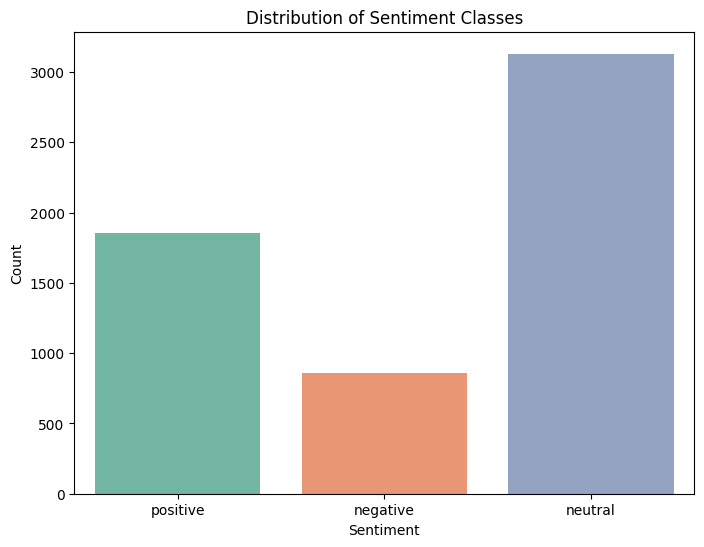

In [6]:
plt.figure(figsize=(8, 6))
sns.countplot(x="Sentiment", data=df, palette="Set2")
plt.title("Distribution of Sentiment Classes")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

In [7]:
encoder = LabelEncoder()
df["Sentiment"] = encoder.fit_transform(df["Sentiment"])

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

2025-05-23 16:49:08.219491: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748018948.488930      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748018948.567378      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df["Sentence"])
sequences = tokenizer.texts_to_sequences(df["Sentence"])
max_length = max(len(x) for x in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

In [10]:
X = padded_sequences
y = df["Sentiment"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Model Architecture
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_length))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

2025-05-23 16:49:25.225505: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [12]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=22, restore_best_weights=True, verbose=1)

fit = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 29s 149ms/step - accuracy: 0.5293 - loss: -2.3237 - val_accuracy: 0.5321 - val_loss: -4.7953
Epoch 2/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 22s 147ms/step - accuracy: 0.5191 - loss: -5.6141 - val_accuracy: 0.5321 - val_loss: -7.3772
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 22s 146ms/step - accuracy: 0.5355 - loss: -8.0763 - val_accuracy: 0.5321 - val_loss: -9.9753
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 22s 146ms/step - accuracy: 0.5406 - loss: -10.6686 - val_accuracy: 0.5321 - val_loss: -12.6071
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 22s 148ms/step - accuracy: 0.5358 - loss: -13.5892 - val_accuracy: 0.5321 - val_loss: -15.1340
Epoch 6/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 22s 149ms/step - accuracy: 0.5339 - loss: -15.9210 - val_accuracy: 0.5321 - val_loss: -17.6595
Epoch 7/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 22s 151ms/step - accuracy: 0.5365 - loss: -18.9463 - val_accuracy: 0.5321 - val_loss: -20.2209
Epoch 8/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 22s 150ms/step - accu

## **Model Evaluation**

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step


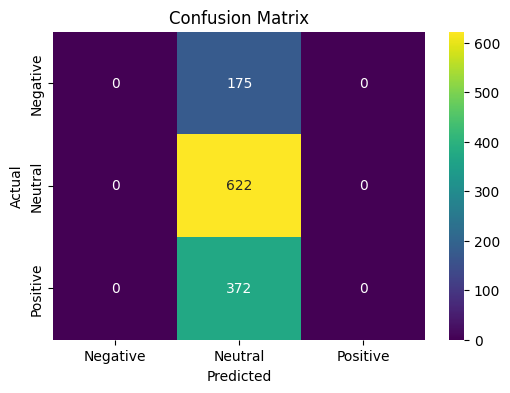

In [15]:
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()